<a href="https://www.kaggle.com/code/yorkyong/churn-prediction-ensemble-learning-v2?scriptVersionId=158988722" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <p style="background-color:red;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">1. Introduction</p>

In this notebook, we embark on a comprehensive journey to enhance the predictive power of our model through advanced feature engineering and ensemble learning. The ensemble comprises well-known gradient boosting algorithms such as CATBoost, XGBoost, and LGBM, each contributing its unique strengths to the overall predictive capability. 

### Feature Engineering
* We begin by exploring and applying the best feature engineering practices found in public notebooks for this competition, the aim is to extract maximum information from our dataset. 
* Please find the credit and references for each notebook that inspired the feature used below.

### Pipelines
* We will then begin to build and assemble the pipeline of data-processing & engineered features.

### Ensemble Learning
* Subsequently, we delve into the world of ensemble learning, combining the strengths of different models with varying weights. 
* The evaluation is centered around the ROC_AUC score, and we visually dissect the model's performance using Confusion Matrix insights. 

### Tuning using Optuna
* To further elevate our model's performance, we employ Optuna for hyperparameter optimization, focusing not only on weight adjustments but also fine-tuning various parameters for each individual model. 
* The goal is to achieve an optimized and robust predictive model ready to tackle the challenges of our dataset.

### Version Log
* This V2 version is different from original version (https://www.kaggle.com/code/yorkyong/churn-prediction-ensemble-w-cb-xgb-lgbm) with the addition of original data set 
* Some minor clean-up of codes not used (e.g. hyperparameter tuning for ensemble)
* Adjusted code for hyperparameter tuning for more efficiency and optimisation

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">2. Import + Load Data</p>

In [1]:
#Basic libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#sklearn library
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,RobustScaler, FunctionTransformer
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, KFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import precision_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import  cross_val_score #Hyperparameter Tuning
from sklearn.model_selection import learning_curve

from sklearn import set_config

# Display the entire pipeline
set_config(display='diagram')


#xgboost library
import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

#lgb library
import lightgbm as lgb
from lightgbm import LGBMClassifier

#catboost library
from catboost import CatBoostClassifier

import optuna


import warnings
# Set global warning filter
warnings.filterwarnings("ignore")
# Suppress LightGBM warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*num_leaves.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*No further splits with positive gain.*")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
sample = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv')
train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')
original=pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')

In [3]:
train.drop(columns=["id"],inplace=True)
test.drop(columns=["id"],inplace=True)
original.drop(columns=['RowNumber'],inplace=True)

train_copy=train.copy()
test_copy=test.copy()
original_copy=original.copy()

original["original"]=1
train["original"]=0
test["original"]=0

train=pd.concat([train,original.dropna()],axis=0)
train.reset_index(inplace=True,drop=True)

trainX = train.drop(['Exited'], axis=1)
trainy = train['Exited']

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">3. Feature Engineering</p>


## Age Binning

In [4]:
class AgeBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['Age'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_Age',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
AgeBinning(5).fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,QCut5_Age
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,3
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,2
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,3
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,3
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,0


## Credit Score Binning

In [5]:
class CreditScoreBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['CreditScore'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_CreditScore',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
CreditScoreBinning(5).fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,QCut5_CreditScore
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,2
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,2
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,3
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,4
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,4
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,4


## Estimated Salary Binning

In [6]:
class SalaryBinning(BaseEstimator, TransformerMixin):
    def __init__(self, n_bins):
        self.n_bins = n_bins
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        transformed = pd.qcut(X['EstimatedSalary'], self.n_bins, labels=False)
        transformed[transformed.isna()] = 0
        transformed_series = pd.Series(transformed, 
                                       name=f'QCut{self.n_bins}_Est_Salary',
                                       index=X.index)
        X_copy = X.copy()
        return pd.concat([X_copy, transformed_series], axis=1)
        
SalaryBinning(10).fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,QCut10_Est_Salary
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,9
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,9
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,3
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,0
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,3
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,3
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,0


## Balance to Salary Ratio
referenced from: https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-eda#%F0%9F%92%BD-Importing-the-data

In [7]:
class BalanceSalaryRatioTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Balance_Salary_Ratio'] = X_copy['Balance'] / X_copy['EstimatedSalary']
        
        return X_copy

BalanceSalaryRatioTransformer().fit_transform(train)        

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,Balance_Salary_Ratio
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,0.000000
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,0.000000
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,0.000000
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,1.760655
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,0.000000
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,0.808230
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,0.808230
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,3.407702


## Geography and Gender interaction
referenced from: https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-eda#%F0%9F%92%BD-Importing-the-data

In [8]:
class GeoGenderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Geo_Gender'] = X_copy['Geography'] + '_' + X_copy['Gender']
        return X_copy
    
GeoGenderTransformer().fit_transform(train)   

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,Geo_Gender
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,France_Male
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,France_Male
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,France_Male
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,France_Male
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,Spain_Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,France_Female
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,Germany_Male
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,Germany_Male
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,France_Female


## Total Prouducts Used
referenced from: https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-eda#%F0%9F%92%BD-Importing-the-data

In [9]:
class TotalProductsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Total_Products_Used'] = X_copy['NumOfProducts'] + X_copy['HasCrCard']
        return X_copy

TotalProductsTransformer().fit_transform(train)   

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,Total_Products_Used
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,3.0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,3.0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,3.0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,2.0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,1.0
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,3.0
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,3.0
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,2.0


## Gender and Total Product interaction
referenced from: https://www.kaggle.com/code/ashishkumarak/playground-s4e1-bank-churn-prediction-eda#%F0%9F%92%BD-Importing-the-data

In [10]:
class TpGenderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, total_products_field='Total_Products_Used', gender_field='Gender'):
        self.total_products_field = total_products_field
        self.gender_field = gender_field
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['Tp_Gender'] = X_copy[self.total_products_field].astype('str') + X_copy[self.gender_field]
        return X_copy

train_tp = TotalProductsTransformer().fit_transform(train)   
TpGenderTransformer().fit_transform(train_tp)    

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,Total_Products_Used,Tp_Gender
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,3.0,3.0Male
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,3.0,3.0Male
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,3.0,3.0Male
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,2.0,2.0Male
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,3.0,3.0Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,1.0,1.0Female
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,3.0,3.0Male
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,3.0,3.0Male
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,2.0,2.0Female


## TFIDF-PCA (Text Transformation)
referenced from: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble#TFIDF-PCA-(Text-Transformation)

In [11]:
class TFIDFPCATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, column, max_features, n_components):
        self.column = column
        self.max_features = max_features
        self.n_components = n_components
        self.vectorizer = TfidfVectorizer(max_features=max_features)
        self.svd = TruncatedSVD(n_components=n_components)

    def fit(self, X, y=None):
        vectors = self.vectorizer.fit_transform(X[self.column])
        self.svd.fit(vectors)
        return self

    def transform(self, X):
        vectors = self.vectorizer.transform(X[self.column])
        svd_result = self.svd.transform(vectors)

        tfidf_df = pd.DataFrame(svd_result, columns=[f"{self.column}_tfidf_{i}" for i in range(self.n_components)])
        X = pd.concat([X, tfidf_df], axis="columns")
        return X
    
TFIDFPCATransformer(column="Surname", max_features=1000, n_components=5).fit_transform(train) 

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,-3.602413e-08,9.398495e-07,-9.531609e-07,-9.588373e-08,2.605363e-06
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1.567344e-06,-1.156246e-06,-2.671689e-06,-1.813257e-06,-7.302068e-06
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,6.496019e-04,-6.189061e-03,2.866207e-03,-8.423700e-03,-4.620857e-02
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,-6.625857e-04,4.950036e-03,-1.135889e-03,1.986610e-03,2.967327e-02
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,8.882564e-08,-1.091691e-06,-7.252085e-07,-1.710076e-06,3.624224e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,-3.274948e-11,2.122631e-10,1.534478e-10,-2.707170e-10,1.903736e-11
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,-9.457621e-11,4.528288e-10,7.268507e-11,-3.428347e-11,1.308648e-09
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,-9.457621e-11,4.528288e-10,7.268507e-11,-3.428347e-11,1.308648e-09
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,-9.125943e-05,1.556797e-04,1.359309e-04,-2.622910e-04,1.044717e-03


## k-Means Clusterer
with reference: https://www.kaggle.com/code/arunklenin/ps4e1-advanced-feature-engineering-ensemble#4.3-Numerical-Clustering

In [12]:
class KMeansClusterer(BaseEstimator, TransformerMixin):
    def __init__(self, features, n_clusters=20, random_state=0, n_components=None):
        self.features = features
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.n_components = n_components
        self.kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=random_state)
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components)
    
    def fit(self, X, y=None):
        X_scaled = self.scaler.fit_transform(X.loc[:, self.features])
        if self.n_components is not None:
            X_scaled = self.pca.fit_transform(X_scaled)
        self.kmeans.fit(X_scaled)
        return self
    
    def transform(self, X):
        X_scaled = self.scaler.transform(X.loc[:, self.features])
        
        # Check for NaN values and replace them with zeros or appropriate values
        if np.isnan(X_scaled).any():
            X_scaled = np.nan_to_num(X_scaled)
        
        if self.n_components is not None:
            X_scaled = self.pca.transform(X_scaled)
        
        X_new = pd.DataFrame()
        X_new["Cluster"] = self.kmeans.predict(X_scaled)
        
        X_copy = X.copy()
        # Convert the "Cluster" column to dense format
        X_new["Cluster"] = X_new["Cluster"].values
        return pd.concat([X_copy.reset_index(drop=True), X_new.reset_index(drop=True)], axis=1)


In [13]:
#With PCA (specify the number of components, e.g., 3)
clusterer_with_pca = KMeansClusterer(features=["CustomerId","EstimatedSalary","Balance"], n_clusters=10, random_state=123, n_components=3)

# Fit and transform your data
clusterer_with_pca.fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,Cluster
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,9
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,7
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,9
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,6
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,0
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,8
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,8
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,8


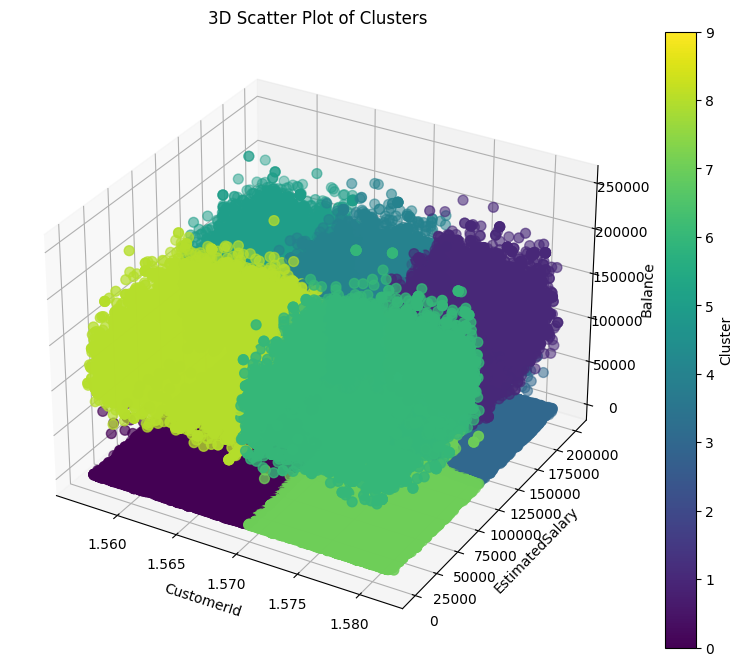

In [14]:
#Visualising the clusters
from mpl_toolkits.mplot3d import Axes3D

# Assuming X_train is your training data
X_train_selected = train[["CustomerId","EstimatedSalary","Balance"]]

# Fit and transform with PCA and KMeansClusterer
clusterer_with_pca.fit(X_train_selected)
X_transformed = clusterer_with_pca.transform(X_train_selected)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of data points colored by cluster
scatter = ax.scatter(X_transformed["CustomerId"], X_transformed["EstimatedSalary"], X_transformed["Balance"], c=X_transformed["Cluster"], cmap='viridis', s=50)

# Add labels and title
ax.set_xlabel("CustomerId")
ax.set_ylabel("EstimatedSalary")
ax.set_zlabel('Balance')
ax.set_title('3D Scatter Plot of Clusters')

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

plt.show()

## Zero Balance Indicator

In [15]:
class BalanceTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Create a binary column indicating if the bank account is zero
        X['Balance_is_zero'] = (X['Balance'] == 0).astype(int)
        
               
        Balance_is_zero_series = pd.Series(X['Balance_is_zero'], 
                                           name='Balance_is_zero',
                                           index=X.index)
        return X
            
BalanceTransformer().fit_transform(train)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,original,Balance_is_zero
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0,1
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0,1
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0,1
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1,1
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,0
175029,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,1,0
175030,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,1,0


# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">4. Assembling the Pipeline</p>

## Column Transformer

In [16]:
#applies transformers to different columns.
multicolumn_prep = ColumnTransformer([ ('encode', 
                                       OneHotEncoder(handle_unknown='ignore'), 
                                       ['Gender', 'Geography','NumOfProducts','HasCrCard','IsActiveMember','Geo_Gender','Tp_Gender']),
                                     ],
                                     remainder='passthrough')
multicolumn_prep

ColumnTransformer(remainder='passthrough',
                  transformers=[('encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Geography', 'NumOfProducts',
                                  'HasCrCard', 'IsActiveMember', 'Geo_Gender',
                                  'Tp_Gender'])])

## Drop Columns

In [17]:
class DropColumn(BaseEstimator, TransformerMixin):
    def __init__(self, cols=[]):
        self.cols = cols
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        
        return X.drop(self.cols, axis=1)

In [18]:
named_preprocessing_pipeline = Pipeline([
    ('kmeans', KMeansClusterer(features=["CustomerId","EstimatedSalary","Balance"], n_clusters=10, random_state=123, n_components=3)),
    ('surname_tfid', TFIDFPCATransformer(column="Surname", max_features=1000, n_components=10)),
    ('age_binning', AgeBinning(7)),
    ('salary_binning', SalaryBinning(7)),
    ('CS_binning', CreditScoreBinning(7)),    
    ('zero_balance', BalanceTransformer()),
    ('balance_salary_ratio', BalanceSalaryRatioTransformer()),
    ('geo_gender', GeoGenderTransformer()),
    ('total_products', TotalProductsTransformer()),
    ('tp_gender', TpGenderTransformer()),
    ('drop', DropColumn(cols=['CustomerId','Surname'])),
    ('prep',ColumnTransformer([ ('encode', 
                                 OneHotEncoder(handle_unknown='ignore',sparse_output=False), 
                                 ['Gender', 
                                  'Geography',
                                  'NumOfProducts',
                                  'HasCrCard',
                                  'IsActiveMember',
                                  'Geo_Gender',
                                  'Tp_Gender',
                                  'Cluster',
                                  'QCut7_Age',
                                  'QCut7_Est_Salary',
                                  'QCut7_CreditScore',
                                  'Total_Products_Used']),
                              ],
                              remainder='passthrough').set_output(transform='pandas')),
])

named_preprocessing_pipeline                 

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CustomerId', 'EstimatedSalary',
                                           'Balance'],
                                 n_clusters=10, n_components=3,
                                 random_state=123)),
                ('surname_tfid',
                 TFIDFPCATransformer(column='Surname', max_features=1000,
                                     n_components=10)),
                ('age_binning', AgeBinning(n_bins=7)),
                ('salary_binning', SalaryBinning(n_bins=7)),
                ('CS_binning', CreditScoreBinning(n_bins...
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Geography',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'Geo_Gender', 'Tp_Gender',
                                                   'Cluster', 'QCut7_Age',
                                                   'QCut7_Est_Salary',
                                                   'QCut7_CreditScore',
                                                   'Total_Products_Used'])]))])

In [19]:
#checking output on train df
df_train = named_preprocessing_pipeline.fit_transform(train.drop(['Exited'], axis=1))
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175032 entries, 0 to 175031
Data columns (total 83 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   encode__Gender_Female              175032 non-null  float64
 1   encode__Gender_Male                175032 non-null  float64
 2   encode__Geography_France           175032 non-null  float64
 3   encode__Geography_Germany          175032 non-null  float64
 4   encode__Geography_Spain            175032 non-null  float64
 5   encode__NumOfProducts_1            175032 non-null  float64
 6   encode__NumOfProducts_2            175032 non-null  float64
 7   encode__NumOfProducts_3            175032 non-null  float64
 8   encode__NumOfProducts_4            175032 non-null  float64
 9   encode__HasCrCard_0.0              175032 non-null  float64
 10  encode__HasCrCard_1.0              175032 non-null  float64
 11  encode__IsActiveMember_0.0         1750

In [20]:
#checking output on test df
df_test = pd.DataFrame(named_preprocessing_pipeline.transform(test))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 83 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   encode__Gender_Female              110023 non-null  float64
 1   encode__Gender_Male                110023 non-null  float64
 2   encode__Geography_France           110023 non-null  float64
 3   encode__Geography_Germany          110023 non-null  float64
 4   encode__Geography_Spain            110023 non-null  float64
 5   encode__NumOfProducts_1            110023 non-null  float64
 6   encode__NumOfProducts_2            110023 non-null  float64
 7   encode__NumOfProducts_3            110023 non-null  float64
 8   encode__NumOfProducts_4            110023 non-null  float64
 9   encode__HasCrCard_0.0              110023 non-null  float64
 10  encode__HasCrCard_1.0              110023 non-null  float64
 11  encode__IsActiveMember_0.0         1100

In [21]:
# Using Standard Scaler or Robust Scaler to scale numeric variables

class StandardScalerNamed(StandardScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)
    
    
class RobustScalerNamed(RobustScaler, TransformerMixin):
    def get_feature_names_out(self, X, y=None):
        return X.columns.tolist()

    def transform(self, X, y=None):
        transformed = super().transform(X, y)
        return pd.DataFrame(transformed, columns=X.columns)

In [22]:
modelling_pipeline = Pipeline(named_preprocessing_pipeline.steps + [('scale',RobustScaler().set_output(transform='pandas')),])
modelling_pipeline

Pipeline(steps=[('kmeans',
                 KMeansClusterer(features=['CustomerId', 'EstimatedSalary',
                                           'Balance'],
                                 n_clusters=10, n_components=3,
                                 random_state=123)),
                ('surname_tfid',
                 TFIDFPCATransformer(column='Surname', max_features=1000,
                                     n_components=10)),
                ('age_binning', AgeBinning(n_bins=7)),
                ('salary_binning', SalaryBinning(n_bins=7)),
                ('CS_binning', CreditScoreBinning(n_bins...
                ('drop', DropColumn(cols=['CustomerId', 'Surname'])),
                ('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encode',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender', 'Geography',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'Geo_Gender', 'Tp_Gender',
                                                   'Cluster', 'QCut7_Age',
                                                   'QCut7_Est_Salary',
                                                   'QCut7_CreditScore',
                                                   'Total_Products_Used'])])),
                ('scale', RobustScaler())])

In [23]:
# modelling_pipeline.fit_transform(train.drop(['Exited'], axis=1))

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">5. Setting up the Models</p>

# XGBoost Classifier

In [24]:
X = train.drop(['Exited'], axis=1) 
y = train['Exited']

In [25]:
#XGBoost best parameters 
# Best Hyperparameters for XGBoost: {'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.02456448139481976, 'n_estimators': 642, 'subsample': 0.4459554630822652, 'colsample_bytree': 0.5384577484675274, 'random_state': 42} Best is trial 11 with value: 0.8931474817419908.


xgb_params_optuna = {'max_depth': 6, 
                     'min_child_weight': 5, 
                     'learning_rate': 0.02456448139481976, 
                     'n_estimators': 642, 
                     'subsample': 0.4459554630822652, 
                     'colsample_bytree': 0.5384577484675274, 
                     'random_state': 42}

# XGBoost model
xgb_model = XGBClassifier(**xgb_params_optuna)

xgb_pipeline = make_pipeline(modelling_pipeline, xgb_model)
xgb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans',
                                  KMeansClusterer(features=['CustomerId',
                                                            'EstimatedSalary',
                                                            'Balance'],
                                                  n_clusters=10, n_components=3,
                                                  random_state=123)),
                                 ('surname_tfid',
                                  TFIDFPCATransformer(column='Surname',
                                                      max_features=1000,
                                                      n_components=10)),
                                 ('age_binning', AgeBinning(n_bins=7)),
                                 ('salary_binning', SalaryBinning(n_bins=7)),
                                 ('CS_binnin...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.02456448139481976, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=642, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [26]:
# # number of folds
# n_splits = 10

# #  StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# #  cross-validation results
# cv_results = []

# # stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     xgb_pipeline.fit(X_train, y_train )

#     # predictions on the validation set
#     y_val_pred_prob = xgb_pipeline.predict(X_val)
#     y_pred = xgb_pipeline.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
    
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     # results
#     cv_results.append(roc_auc)

# # average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')

**#Results from XGBoost xgb_params_optuna:**

Fold 1, AUC Score on Validation Set: 0.7509911752017777
Fold 1, F1 Score on Validation Set: 0.8609183252455748
----------------------------------------------------------------------
Fold 2, AUC Score on Validation Set: 0.7504207360812228
Fold 2, F1 Score on Validation Set: 0.857965529741298
----------------------------------------------------------------------
Fold 3, AUC Score on Validation Set: 0.7564072797319356
Fold 3, F1 Score on Validation Set: 0.8618888662091738
----------------------------------------------------------------------
Fold 4, AUC Score on Validation Set: 0.7527624268792698
Fold 4, F1 Score on Validation Set: 0.8588526538940561
----------------------------------------------------------------------
Fold 5, AUC Score on Validation Set: 0.7575888477423931
Fold 5, F1 Score on Validation Set: 0.8616646460825647
----------------------------------------------------------------------
Fold 6, AUC Score on Validation Set: 0.748611148996823
Fold 6, F1 Score on Validation Set: 0.8581639046663991
----------------------------------------------------------------------
Fold 7, AUC Score on Validation Set: 0.7520976698092472
Fold 7, F1 Score on Validation Set: 0.859116670770366
----------------------------------------------------------------------
Fold 8, AUC Score on Validation Set: 0.7461015798498597
Fold 8, F1 Score on Validation Set: 0.8563110810190951
----------------------------------------------------------------------
Fold 9, AUC Score on Validation Set: 0.7496059820650608
Fold 9, F1 Score on Validation Set: 0.8593222243163775
----------------------------------------------------------------------
Fold 10, AUC Score on Validation Set: 0.7542280356409966
Fold 10, F1 Score on Validation Set: 0.8606702675502771
----------------------------------------------------------------------

Average AUC-score across 10 folds: 0.7518814881998587

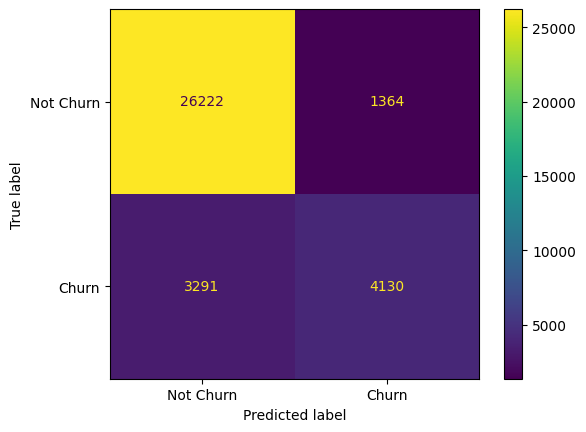

In [27]:
# Assuming trainX and trainy are your features and target variable
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

xgb_pipeline.fit(X = X_train,
                y = y_train)

predictions_xgb = xgb_pipeline.predict(X_val)

cm_xgb = confusion_matrix(y_val, predictions_xgb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

In [28]:
# # To intepret the learning curve https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5
# # PLotting a Learning Curve

# stratkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# train_sizes, train_scores, test_scores = learning_curve(
#     xgb_pipeline, X_train, y_train, cv=stratkf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Score")

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.grid()

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#          label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#          label="Cross-validation score")

# plt.legend(loc="best")
# plt.show()

# LGBM Classifier
* enable GPU Accelerator: GPU P100

In [29]:
#LGBM Best parameters:  
lgbm_params_optuna =  {'max_depth': 5, 
                       'num_leaves': 28, 
                       'min_child_samples': 18, 
                       'learning_rate': 0.04402414018650732, 
                       'n_estimators': 902, 
                       'subsample': 0.8099502200990975, 
                       'colsample_bytree': 0.20378880662842785, 
                       'reg_alpha': 0.0415447006361207, 
                       'reg_lambda': 0.9581806475187282,
                       'device': 'gpu',
                       'verbosity': 0}

    
# lgbm model
lgbm_model = LGBMClassifier(**lgbm_params_optuna)

lgbm_pipeline = make_pipeline(modelling_pipeline, lgbm_model)
lgbm_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans',
                                  KMeansClusterer(features=['CustomerId',
                                                            'EstimatedSalary',
                                                            'Balance'],
                                                  n_clusters=10, n_components=3,
                                                  random_state=123)),
                                 ('surname_tfid',
                                  TFIDFPCATransformer(column='Surname',
                                                      max_features=1000,
                                                      n_components=10)),
                                 ('age_binning', AgeBinning(n_bins=7)),
                                 ('salary_binning', SalaryBinning(n_bins=7)),
                                 ('CS_binnin...
                                                                    'QCut7_CreditScore',
                                                                    'Total_Products_Used'])])),
                                 ('scale', RobustScaler())])),
                ('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.20378880662842785,
                                device='gpu', learning_rate=0.04402414018650732,
                                max_depth=5, min_child_samples=18,
                                n_estimators=902, num_leaves=28,
                                reg_alpha=0.0415447006361207,
                                reg_lambda=0.9581806475187282,
                                subsample=0.8099502200990975, verbosity=0))])

In [30]:
# # folds
# n_splits = 10

# # StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# cv_results = []


# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):

#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     lgbm_pipeline.fit(X_train,y_train)

#     y_val_pred_prob = lgbm_pipeline.predict_proba(X_val)
#     y_pred = lgbm_pipeline.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     logloss = log_loss(y_val, y_val_pred_prob)
#     roc_auc = roc_auc_score(y_val, y_pred)
#     print(f'Fold {fold + 1}, AUC-Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     cv_results.append(roc_auc)
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-SCORE across {n_splits} folds: {average_cv_result}')

**#Results from LGBM lgbm_params_optuna:**

Average AUC-SCORE across 10 folds: 0.7543273220488345

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

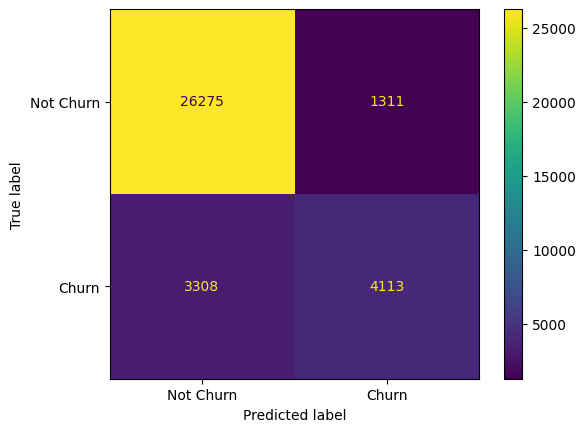

In [31]:
# Assuming trainX and trainy are your features and target variable
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

lgbm_pipeline.fit(X = X_train,
                y = y_train)

predictions_lgbm = lgbm_pipeline.predict(X_val)

cm_lgbm = confusion_matrix(y_val, predictions_lgbm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

In [32]:
# # To intepret the learning curve https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5
# # PLotting a Learning Curve

# stratkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# train_sizes, train_scores, test_scores = learning_curve(
#     lgbm_pipeline, X_train, y_train, cv=stratkf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Score")

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.grid()

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#          label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#          label="Cross-validation score")

# plt.legend(loc="best")
# plt.show()

# CatBoost Classifier

In [33]:
catboost_params_optuna = {'iterations': 943, 
                          'depth': 6, 
                          'min_data_in_leaf': 2, 
                          'learning_rate': 0.040480194708314994,
                          'grow_policy': 'Lossguide',
                          'bootstrap_type': 'Bernoulli',
                          'eval_metric': 'AUC'}

# catboost model
cb_model = CatBoostClassifier(**catboost_params_optuna, random_state=42, verbose=0)


cb_pipeline = make_pipeline(modelling_pipeline, cb_model)
cb_pipeline

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('kmeans',
                                  KMeansClusterer(features=['CustomerId',
                                                            'EstimatedSalary',
                                                            'Balance'],
                                                  n_clusters=10, n_components=3,
                                                  random_state=123)),
                                 ('surname_tfid',
                                  TFIDFPCATransformer(column='Surname',
                                                      max_features=1000,
                                                      n_components=10)),
                                 ('age_binning', AgeBinning(n_bins=7)),
                                 ('salary_binning', SalaryBinning(n_bins=7)),
                                 ('CS_binnin...
                                                    transformers=[('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False),
                                                                   ['Gender',
                                                                    'Geography',
                                                                    'NumOfProducts',
                                                                    'HasCrCard',
                                                                    'IsActiveMember',
                                                                    'Geo_Gender',
                                                                    'Tp_Gender',
                                                                    'Cluster',
                                                                    'QCut7_Age',
                                                                    'QCut7_Est_Salary',
                                                                    'QCut7_CreditScore',
                                                                    'Total_Products_Used'])])),
                                 ('scale', RobustScaler())])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7dc0dfef7d30>)])

In [34]:
# n_splits = 10

# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


# cv_results = []


# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

    
#     cb_pipeline.fit(X_train,y_train)

#     y_val_pred_prob = cb_pipeline.predict_proba(X_val)
#     y_pred = cb_pipeline.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
#     logloss = log_loss(y_val, y_val_pred_prob)
#     roc_auc = roc_auc_score(y_val, y_pred)
#     print(f'Fold {fold + 1}, AUC- score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print(f'Fold {fold + 1}, Log Loss Score on Validation Set: {logloss}')
#     print('-'*70)

 
#     cv_results.append(logloss)

# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage Logarithmic Loss across {n_splits} folds: {average_cv_result}')

**#Results from CatBoost catboost_params_optuna:**

Fold 1, AUC- score on Validation Set: 0.7517072416768246
Fold 1, F1 Score on Validation Set: 0.8600097876923807
Fold 1, Log Loss Score on Validation Set: 0.31217946171510635
----------------------------------------------------------------------
Fold 2, AUC- score on Validation Set: 0.7533340669566045
Fold 2, F1 Score on Validation Set: 0.8595399588078277
Fold 2, Log Loss Score on Validation Set: 0.31597709764826587
----------------------------------------------------------------------
Fold 3, AUC- score on Validation Set: 0.7586238469354314
Fold 3, F1 Score on Validation Set: 0.8623525839822523
Fold 3, Log Loss Score on Validation Set: 0.31393817095267285
----------------------------------------------------------------------
Fold 4, AUC- score on Validation Set: 0.7557311218633374
Fold 4, F1 Score on Validation Set: 0.8607395797792048
Fold 4, Log Loss Score on Validation Set: 0.315300416436088
----------------------------------------------------------------------
Fold 5, AUC- score on Validation Set: 0.7628893854268665
Fold 5, F1 Score on Validation Set: 0.8637979458153465
Fold 5, Log Loss Score on Validation Set: 0.31267556969571964
----------------------------------------------------------------------
Fold 6, AUC- score on Validation Set: 0.7533439202995406
Fold 6, F1 Score on Validation Set: 0.8601477605628979
Fold 6, Log Loss Score on Validation Set: 0.3158715605016323
----------------------------------------------------------------------
Fold 7, AUC- score on Validation Set: 0.7537913962802606
Fold 7, F1 Score on Validation Set: 0.8595771056277052
Fold 7, Log Loss Score on Validation Set: 0.3179189025814372
----------------------------------------------------------------------
Fold 8, AUC- score on Validation Set: 0.7478390153278797
Fold 8, F1 Score on Validation Set: 0.8564882242315051
Fold 8, Log Loss Score on Validation Set: 0.3188412844122816
----------------------------------------------------------------------
Fold 9, AUC- score on Validation Set: 0.7515873394730135
Fold 9, F1 Score on Validation Set: 0.859716124558027
Fold 9, Log Loss Score on Validation Set: 0.31423116200838164
----------------------------------------------------------------------
Fold 10, AUC- score on Validation Set: 0.7560570434972912
Fold 10, F1 Score on Validation Set: 0.8611976674244601
Fold 10, Log Loss Score on Validation Set: 0.3103113756094012
----------------------------------------------------------------------

Average Logarithmic Loss across 10 folds: 0.3147245001560987

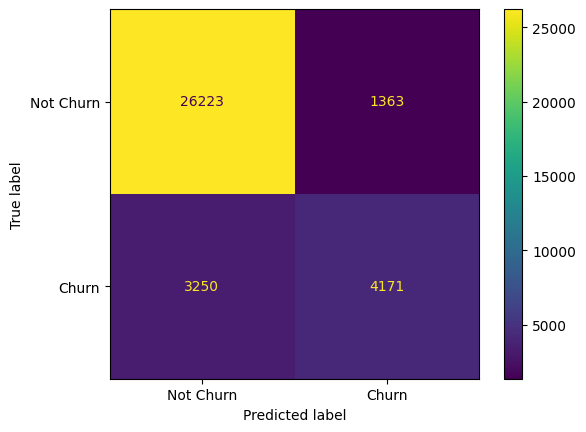

In [35]:
# Assuming trainX and trainy are your features and target variable
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

cb_pipeline.fit(X = X_train,
                y = y_train)

predictions_cb = cb_pipeline.predict(X_val)

cm_cb = confusion_matrix(y_val, predictions_cb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=['Not Churn', 'Churn'])
disp.plot()
plt.show()

In [36]:
# # To intepret the learning curve https://towardsdatascience.com/learning-curve-to-identify-overfitting-underfitting-problems-133177f38df5
# # PLotting a Learning Curve

# stratkf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# train_sizes, train_scores, test_scores = learning_curve(
#     cb_pipeline, X_train, y_train, cv=stratkf, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# plt.figure()
# plt.title("Learning Curve")
# plt.xlabel("Training examples")
# plt.ylabel("Score")

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.grid()

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#          label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#          label="Cross-validation score")

# plt.legend(loc="best")
# plt.show()

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">6. Hyperparameter Tuning with Optuna</p>

## Hyperparameter tuning for XGBoost

In [37]:
# from sklearn.model_selection import  cross_val_score

# def objective_xgb(trial):
#     """Define the objective function for XGBClassifier"""

#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
#         'random_state': trial.suggest_categorical('random_state', [42]),
#         'tree_method': 'hist',  # Use GPU for training
#         'device' : 'cuda',
#         'eval_metric': 'auc',  # Evaluation metric
#         'verbosity': 2,  # Set verbosity to 0 for less output
#     }

#     xgb_model = xgb.XGBClassifier(**params)
#     xgb_pipeline = make_pipeline(modelling_pipeline, xgb_model)

#     # Assuming 'trainX' and 'trainy' are your training data
#     cv = abs(cross_val_score(xgb_pipeline, trainX, trainy, cv=skf, scoring='roc_auc').mean())

#     return cv

# # Define a pruning callback for Optuna
# def pruning_callback(study, trial):
#     if study.best_trial.number != trial.number:
#         # Prune if the trial is not the current best
#         if study.trials[trial.number].intermediate_values:
#             last_value = max(study.trials[trial.number].intermediate_values.values())
#             if last_value < study.best_value:
#                 raise optuna.TrialPruned()
            
# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=30, callbacks=[pruning_callback])

# # Get the best parameters
# best_params_xgb = study.best_params
# print("Best Hyperparameters for XGBoost:", best_params_xgb)

* Best Hyperparameters for XGBoost: {'max_depth': 6, 'min_child_weight': 5, 'learning_rate': 0.02456448139481976, 'n_estimators': 642, 'subsample': 0.4459554630822652, 'colsample_bytree': 0.5384577484675274, 'random_state': 42} Best is trial 11 with value: 0.8931474817419908.

## Hyperparameter tuning for LGBM

In [38]:
# # Define a pruning callback for Optuna
# def pruning_callback(study, trial):
#     if study.best_trial.number != trial.number:
#         # Prune if the trial is not the current best
#         if study.trials[trial.number].intermediate_values:
#             last_value = max(study.trials[trial.number].intermediate_values.values())
#             if last_value < study.best_value:
#                 raise optuna.TrialPruned()

# def objective_lgbm(trial):
#     """Define the objective function for LGBMClassifier"""

#     params = {
#         'objective': 'binary',  # Objective for binary classification
#         'boosting_type': 'gbdt',
#         'device': 'gpu',
#         'metric': 'auc',  # Evaluation metric
#         'max_depth': trial.suggest_int('max_depth', 5, 10),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 150, 1000),
#         'subsample': trial.suggest_float('subsample', 0.1, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
#         'random_state': 42,
#     }

#     lgb_model = lgb.LGBMClassifier(**params)
#     lgb_pipeline = make_pipeline(modelling_pipeline, lgb_model)

#     # Assuming 'trainX' and 'trainy' are your training data
#     cv = abs(cross_val_score(lgb_pipeline, trainX, trainy, cv=skf, scoring='roc_auc').mean())

#     return cv

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# study = optuna.create_study(direction='maximize')
# study.optimize(objective_lgbm, n_trials=30, callbacks=[pruning_callback])

# # Get the best parameters
# best_params_lgb = study.best_params
# print("Best Hyperparameters for LGBM:", best_params_lgb)


* Best Hyperparameters for LGBM: {'max_depth': 5, 
                       'num_leaves': 28, 
                       'min_child_samples': 18, 
                       'learning_rate': 0.04402414018650732, 
                       'n_estimators': 902, 
                       'subsample': 0.8099502200990975, 
                       'colsample_bytree': 0.20378880662842785, 
                       'reg_alpha': 0.0415447006361207, 
                       'reg_lambda': 0.9581806475187282,
                       'device': 'gpu',
                       'verbosity': 0}

## Hyperparameter tuning for CatBoost

In [39]:
# # Suppress FutureWarnings related to is_sparse
# warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int('iterations', 500, 1000),
#         'depth': trial.suggest_int('depth', 5, 15),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
#         'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
#     }
    
#     cb_model = CatBoostClassifier(**params, random_state=42, grow_policy='Lossguide', verbose=0)
#     cb_pipeline = make_pipeline(modelling_pipeline, cb_model)

#     # Using cross_val_score with 'cv' parameter
#     cv = cross_val_score(cb_pipeline, trainX, trainy, cv=skf, scoring='roc_auc', n_jobs=-1).mean()

#     return cv

# # Create an Optuna study with pruning
# study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())

# # Perform the optimization with more trials
# study.optimize(objective, n_trials=30)

# # Get the best hyperparameters
# best_params_cb = study.best_params
# print("Best Hyperparameters for CatBoost:", best_params_cb)

* Best Hyperparameters for CatBoost: {'iterations': 943, 
                          'depth': 6, 
                          'min_data_in_leaf': 2, 
                          'learning_rate': 0.040480194708314994,
                          'grow_policy': 'Lossguide',
                          'bootstrap_type': 'Bernoulli',
                          'eval_metric': 'AUC'}


# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">7. Setting up the Ensemble</p>


In [40]:
from sklearn.ensemble import VotingClassifier

In [41]:
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_pipeline),
    ('lgb', lgbm_pipeline),
    ('cb', cb_pipeline)
        
]
                                  , voting='soft',
                                  weights = [3.5,3,3.5]) 

ensemble_model

VotingClassifier(estimators=[('xgb',
                              Pipeline(steps=[('pipeline',
                                               Pipeline(steps=[('kmeans',
                                                                KMeansClusterer(features=['CustomerId',
                                                                                          'EstimatedSalary',
                                                                                          'Balance'],
                                                                                n_clusters=10,
                                                                                n_components=3,
                                                                                random_state=123)),
                                                               ('surname_tfid',
                                                                TFIDFPCATransformer(column='Surname',
                                                                                    max_features=1000,
                                                                                    n_components=10)),
                                                               ('age_binning',
                                                                AgeBinning(n_bins=7)),
                                                               ('salary_binning',...
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse_output=False),
                                                                                                 ['Gender',
                                                                                                  'Geography',
                                                                                                  'NumOfProducts',
                                                                                                  'HasCrCard',
                                                                                                  'IsActiveMember',
                                                                                                  'Geo_Gender',
                                                                                                  'Tp_Gender',
                                                                                                  'Cluster',
                                                                                                  'QCut7_Age',
                                                                                                  'QCut7_Est_Salary',
                                                                                                  'QCut7_CreditScore',
                                                                                                  'Total_Products_Used'])])),
                                                               ('scale',
                                                                RobustScaler())])),
                                              ('catboostclassifier',
                                               <catboost.core.CatBoostClassifier object at 0x7dc0dfef7d30>)]))],
                 voting='soft', weights=[3.5, 3, 3.5])

In [42]:
# # number of folds
# n_splits = 10

# #  StratifiedKFold
# stratkf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# #  cross-validation results
# cv_results = []

# # stratified k-fold cross-validation
# for fold, (train_idx, val_idx) in enumerate(stratkf.split(X, y)):
#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y[train_idx], y[val_idx]

#     ensemble_model.fit(X_train, y_train )

#     # predictions on the validation set
#     y_val_pred_prob = ensemble_model.predict(X_val)
#     y_pred = ensemble_model.predict(X_val)
        
#     f1=  f1_score(y_val, y_pred, average='weighted')

#     # Evaluating the model
    
#     roc_auc = roc_auc_score(y_val, y_val_pred_prob)
#     print(f'Fold {fold + 1}, AUC Score on Validation Set: {roc_auc}')
#     print(f'Fold {fold + 1}, F1 Score on Validation Set: {f1}')
#     print('-'*70)

#     # results
#     cv_results.append(roc_auc)

# # average cross-validation result
# average_cv_result = sum(cv_results) / n_splits
# print(f'\nAverage AUC-score across {n_splits} folds: {average_cv_result}')

In [43]:
# # Assuming trainX and trainy are your features and target variable
# X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.2, random_state=42)

# ensemble_model.fit(X = X_train, y = y_train)

# predictions_ensemble = ensemble_model.predict(X_val)

# cm_ensemble = confusion_matrix(y_val, predictions_ensemble)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=['Not Churn', 'Churn'])
# disp.plot()
# plt.show()

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">8. Hyperparameter Tuning for Ensemble Weight</p>


In [44]:
# # Define the parameter search space
# def objective(trial):
#     weights = [
#         trial.suggest_float('weight_xgb', 0, 1),  # Adjust the range based on your expectations
#         trial.suggest_float('weight_lgb', 0, 1),
#         trial.suggest_float('weight_cb', 0, 1)
#     ]

#     ensemble_model = VotingClassifier(
#         estimators=[
#             ('xgb', xgb_pipeline),
#             ('lgb', lgbm_pipeline),
#             ('cb', cb_pipeline)
#         ], voting='soft', weights=weights)

#     # Assuming 'trainX' and 'trainy' are your training data
#     cv = abs(cross_val_score(ensemble_model, trainX, trainy, cv=skf, scoring='roc_auc').mean())

#     return cv

# # Assuming 'skf' is your StratifiedKFold object
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Use the 'sampler' parameter for parallelization
# study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# study.optimize(objective, n_trials=50)

# best_weights = study.best_params
# print("Best Weights for Ensemble:", best_weights)


In [45]:
# # Define the parameter grid for weights
# param_grid = {'weights': [(round(w1, 2), round(w2, 2), round(w3, 2))
#                            for w1 in np.arange(0.0, 1.0, 0.1)
#                            for w2 in np.arange(0.0, 1.0, 0.1)
#                            for w3 in np.arange(0.0, 1.0, 0.1)
#                            if round(w1 + w2 + w3, 2) == 1.0]}

# # Extract weights from the parameter grid
# weights_combinations = param_grid['weights']

# # Display the combinations
# for combination in weights_combinations:
#     print(combination)

In [46]:
# import itertools
# import numpy as np

# # Define the possible values for weights
# weights_range = np.arange(0.0, 1.1, 0.1)

# # Generate all possible combinations of weights
# weight_combinations = itertools.product(weights_range, repeat=3)

# # Filter combinations where the sum is 1.0
# valid_weight_combinations = [weights for weights in weight_combinations if round(sum(weights), 2) == 1.0]

# # Display the combinations
# for combination in valid_weight_combinations:
#     print(combination)

In [47]:
# # Define the parameter grid for weights
# param_grid = {'weights': [(round(w1, 2), round(w2, 2), round(w3, 2))
#                            for w1 in np.arange(0.0, 1.0, 0.1)
#                            for w2 in np.arange(0.0, 1.0, 0.1)
#                            for w3 in np.arange(0.0, 1.0, 0.1)
#                            if round(w1 + w2 + w3, 2) == 1.0]}

# # Create the VotingClassifier
# ensemble_model = VotingClassifier(estimators=[
#     ('xgb', xgb_pipeline),
#     ('lgb', lgbm_pipeline),
#     ('cb', cb_pipeline)
# ], voting='soft')

# # Create a StratifiedKFold instance
# stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# # Perform grid search
# grid_search = GridSearchCV(estimator=ensemble_model,
#                            param_grid=param_grid,
#                            scoring='roc_auc',
#                            cv=stratified_kfold,
#                            verbose=2)
                           
# # Fit the grid search
# grid_search.fit(trainX, trainy)

# # Get the best weights
# best_weights = grid_search.best_params_['weights']
# best_weights

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">9. Review of Features</p>

## XGB Feature Importance

In [48]:
# Access individual base models' feature importances
xgb_feature_importance = xgb_pipeline.named_steps['xgbclassifier'].feature_importances_

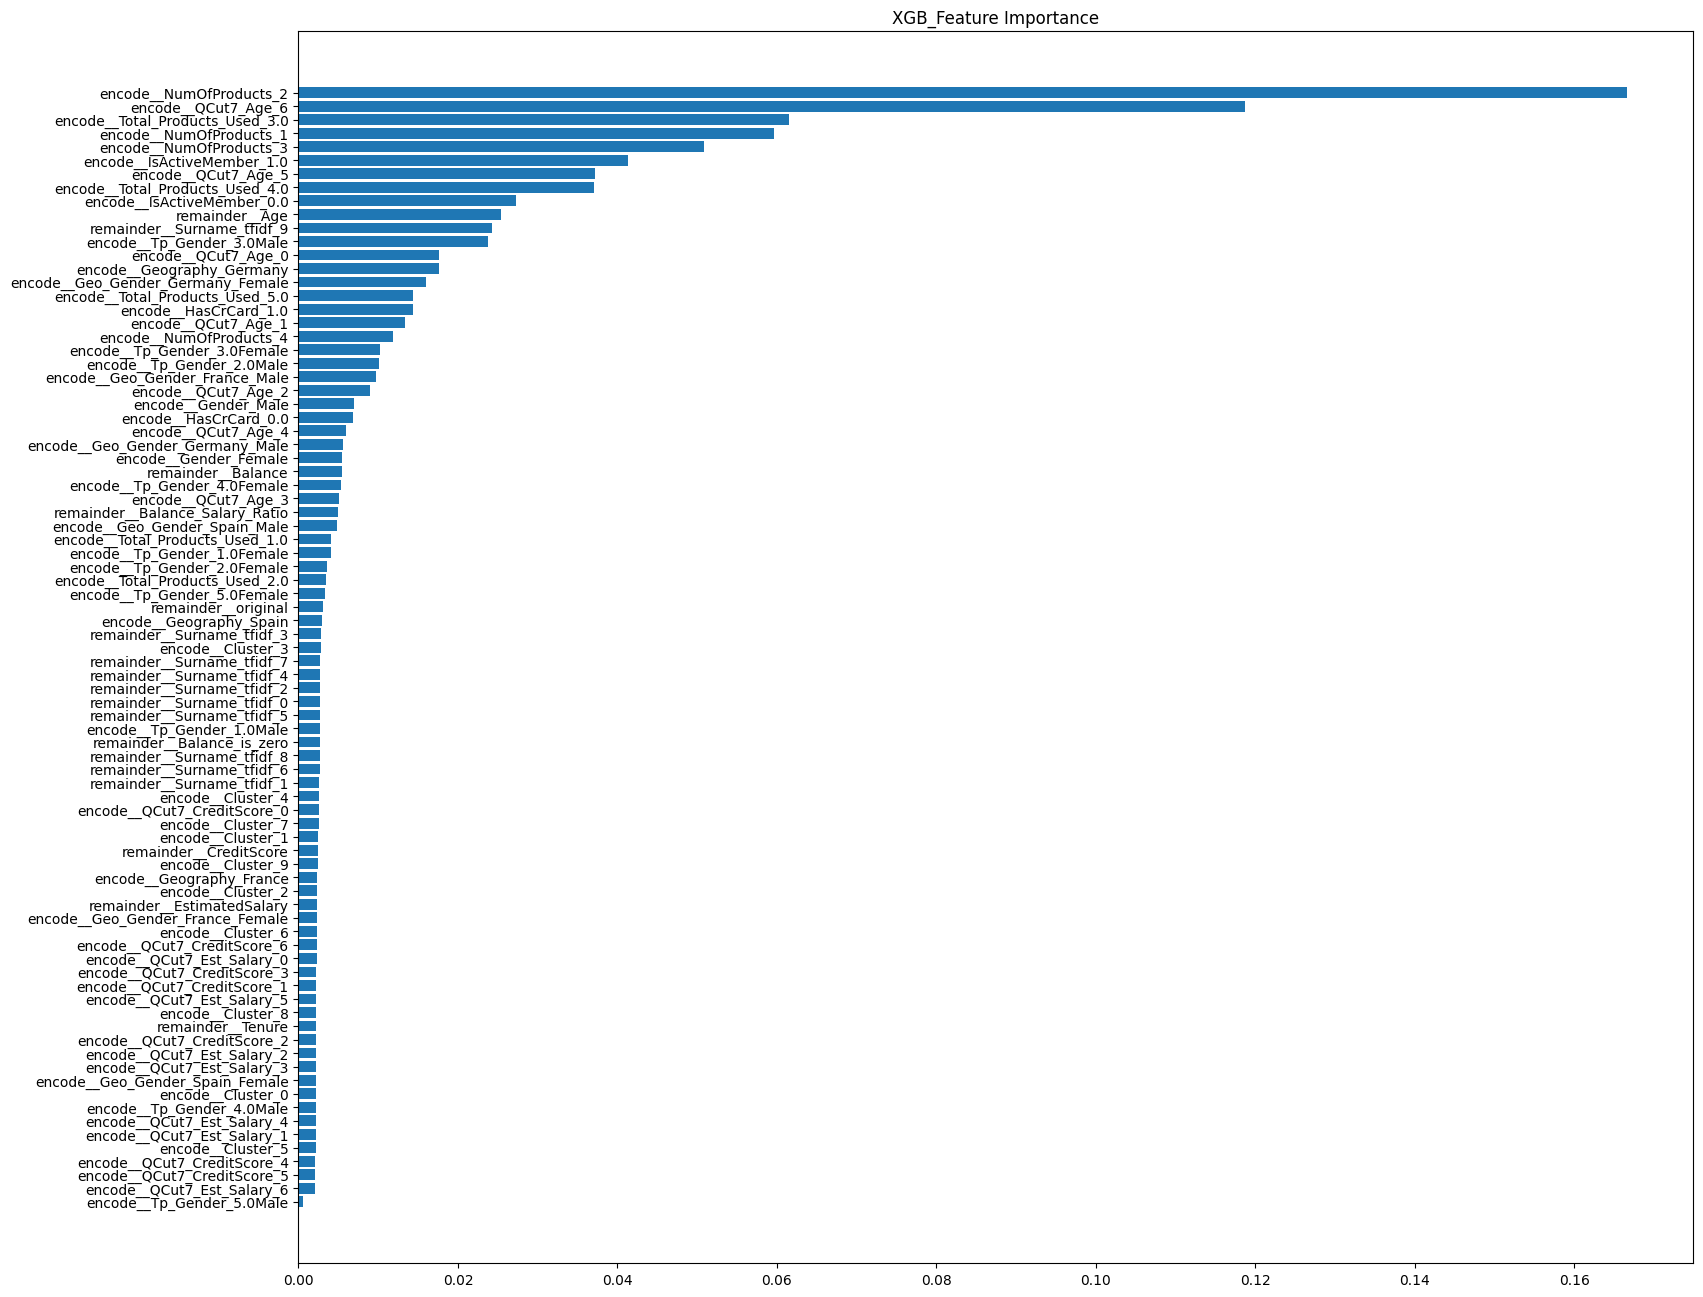

In [49]:
train_X = modelling_pipeline.fit_transform(train.drop(['Exited'], axis=1))


sorted_idx = np.argsort(xgb_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), xgb_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('XGB_Feature Importance')
plt.show()


## LGBM Feature Importance

In [50]:
# Access individual base models' feature importances
lgbm_feature_importance = lgbm_pipeline.named_steps['lgbmclassifier'].feature_importances_

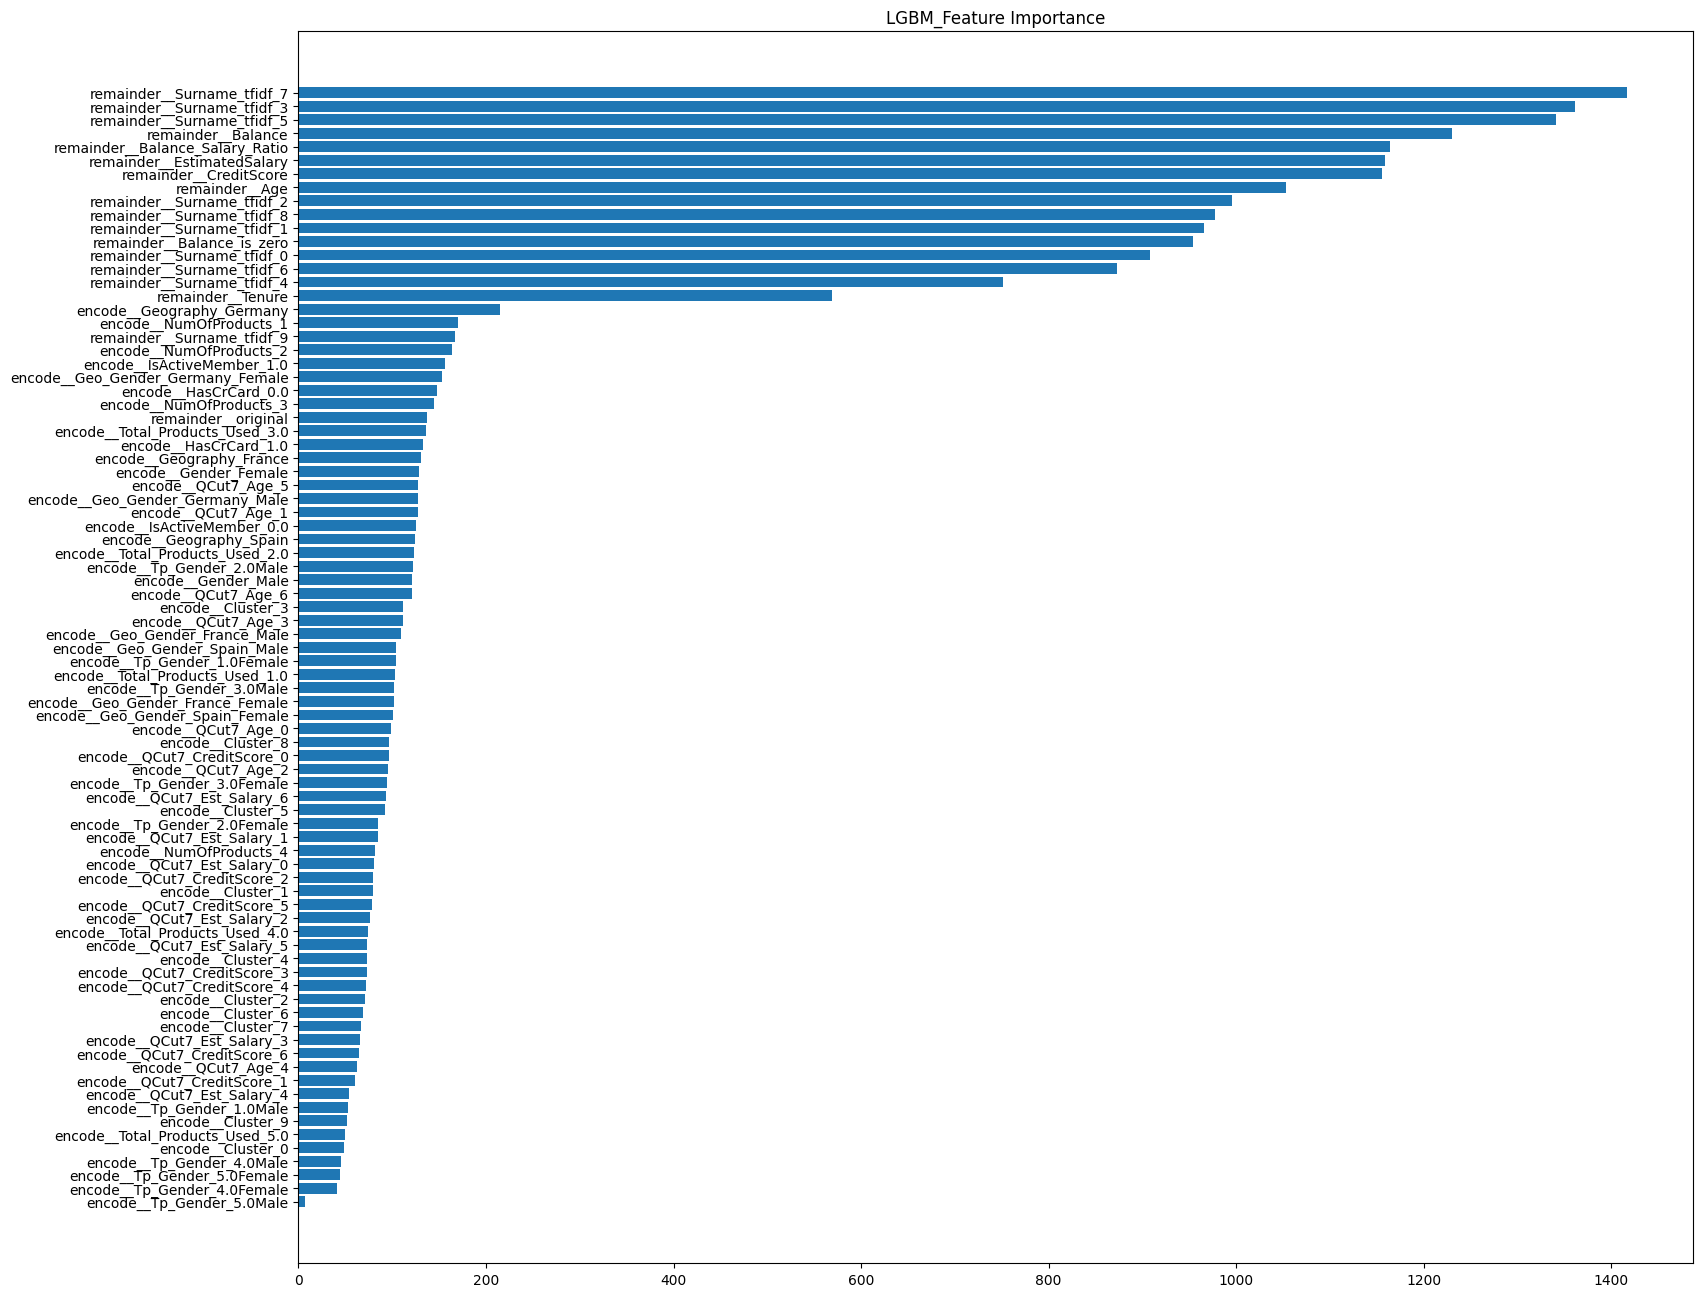

In [51]:
sorted_idx = np.argsort(lgbm_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), lgbm_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('LGBM_Feature Importance')
plt.show()


## CatBoost Feature Importance

In [52]:
# Access individual base models' feature importances
cb_feature_importance = cb_pipeline.named_steps['catboostclassifier'].feature_importances_

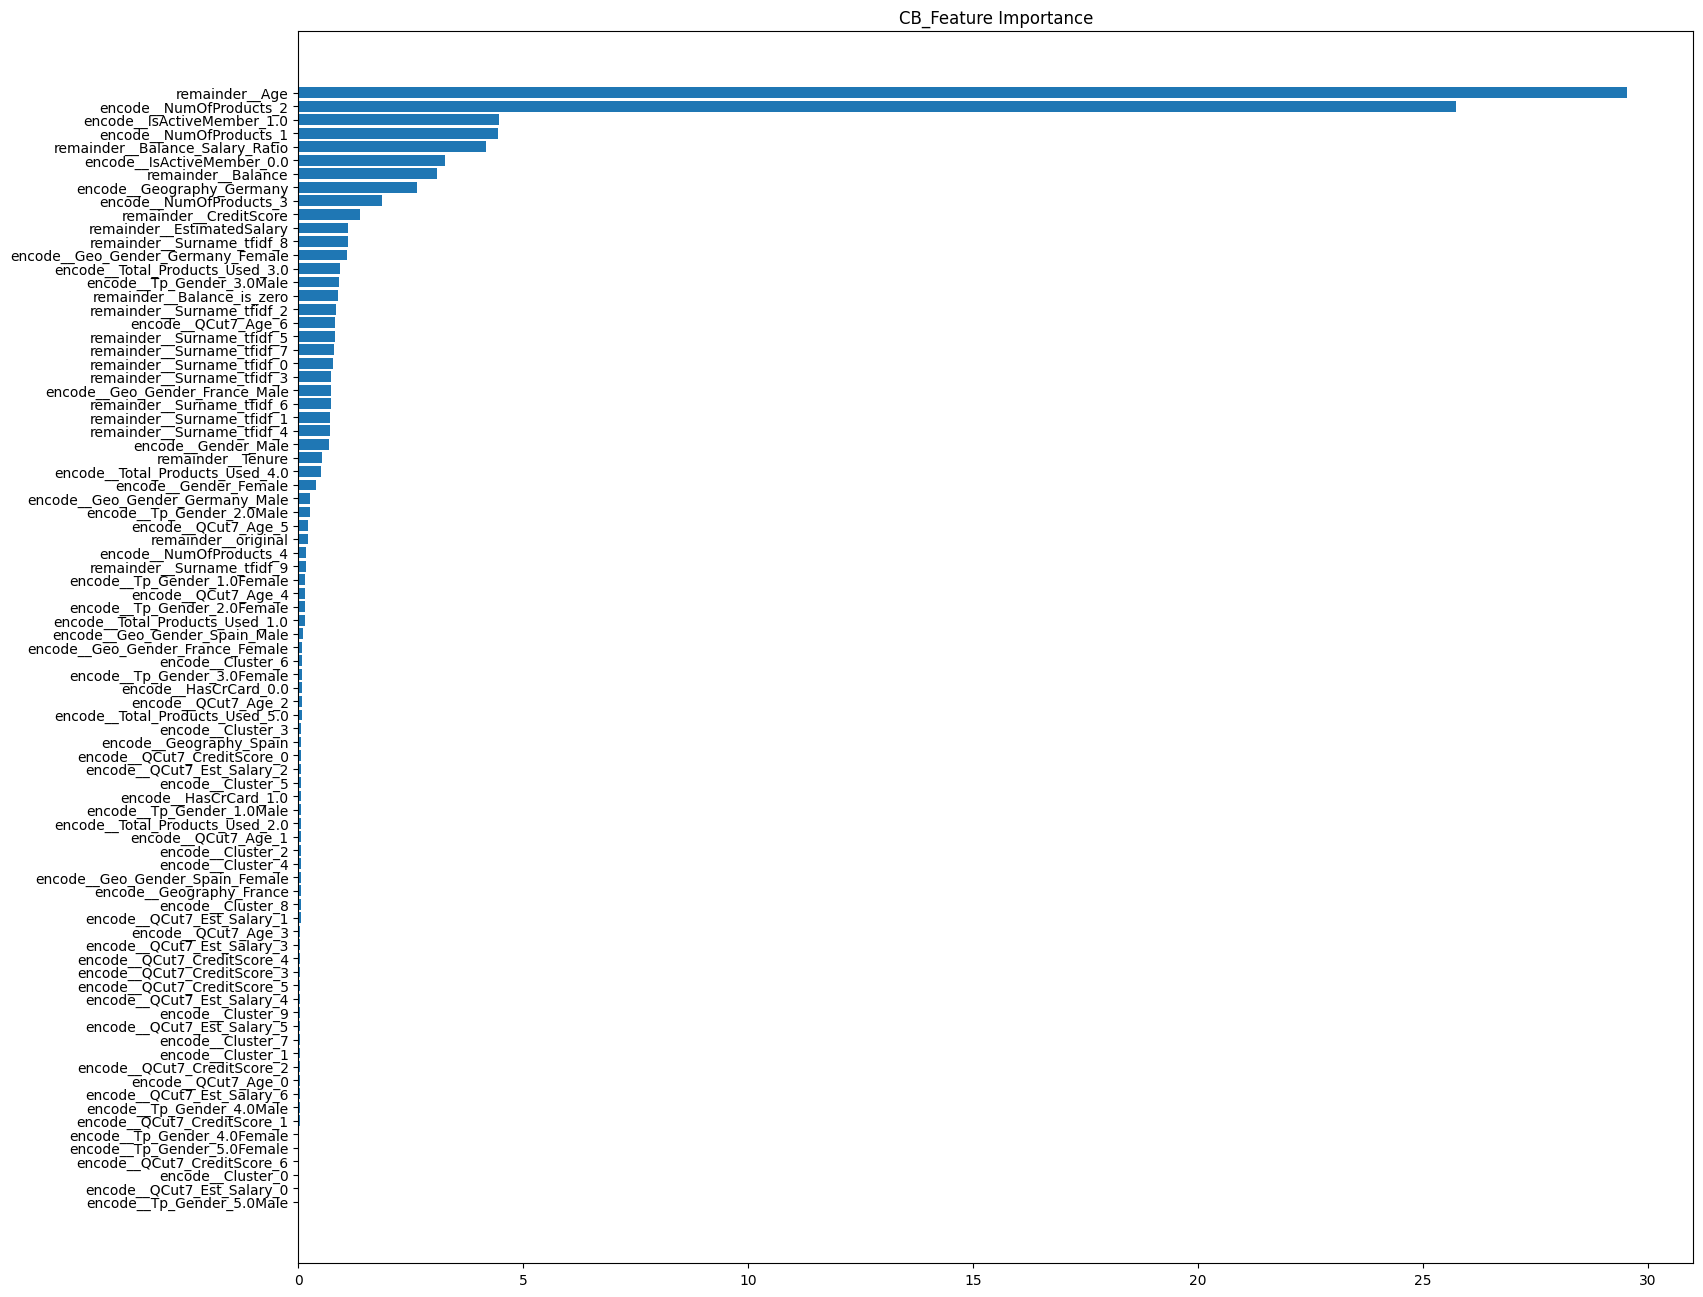

In [53]:
sorted_idx = np.argsort(cb_feature_importance)
fig = plt.figure(figsize=(18, 16))
plt.barh(range(len(sorted_idx)), cb_feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train_X.columns)[sorted_idx])
plt.title('CB_Feature Importance')
plt.show()

# <p style="background-color:red ;color:white;font-family:cursive ;font-size:110%;text-align:center;border-radius: 15px 50px;">10. Submission</p>

In [54]:
# # Fit the ensemble baseline model
# ensemble_model.fit(X=train.drop(['Exited'], axis=1), y=train['Exited'])

# # Create submission file with probability predictions
# predictions = ensemble_model.predict_proba(test)[:, 1]  # Use the probabilities of class 1

# sample['Exited'] = predictions
# sample.to_csv('submission_ensemble_baseline.csv', index=False)


In [55]:
# Fit the ensemble final model
ensemble_model.fit(X=train.drop(['Exited'], axis=1), y=train['Exited'])

# Create submission file with probability predictions
predictions = ensemble_model.predict_proba(test)[:, 1]  # Use the probabilities of class 1

sample['Exited'] = predictions
sample.to_csv('submission_ensemble_final.csv', index=False)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [56]:
sample.head()

,id,Exited
0,165034,0.016465
1,165035,0.735250
2,165036,0.035226
3,165037,0.215697
4,165038,0.384425
